# Multi-label Patent Classification with Neural Networks

In [420]:
# import packages 
import tensorflow as tf
import pandas as pd  
import numpy as np 
import gzip
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Input, Embedding, Reshape, Flatten, Conv1D, Conv2D, MaxPool2D, GlobalMaxPool1D, SpatialDropout1D
from keras.preprocessing import text, sequence
from keras import utils
from keras import optimizers, models
from sklearn import model_selection, preprocessing
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import zipfile
import keras_metrics


%matplotlib inline

### Loading the Data

Dataset: 

https://www.google.com/googlebooks/uspto-patents-grants-text.html#2015

The parsing and preprocessing of the patent files can be found here: 

https://github.com/cpapadimitriou/W266-Final-Project/blob/master/preparation/parse_xml.py

In [475]:
# load data 

# features 
current_dir = %pwd
abstract = pd.read_table(current_dir+'/out_zipped/docNumberToAbsText.txt.gz',compression='gzip', header=None)
abstract = abstract[0].str.split('|', expand=True).rename(columns={0:'doc_num',1:'abstract'})

claim = pd.read_table(current_dir+'/out_zipped/docNumberToClaimText.txt.gz',compression='gzip',  header=None)
claim = claim[0].str.split('|', expand=True).rename(columns={0:'doc_num',1:'claim'})

desc = pd.read_table(current_dir+'/out_zipped/docNumberToDescText.txt.gz',compression='gzip', header=None)
desc = desc[0].str.split('|', expand=True).rename(columns={0:'doc_num',1:'desc'})

title = pd.read_table(current_dir+'/out_zipped/docNumberToInvTitle.txt.gz',compression='gzip', header=None)
title = title[0].str.split('|', expand=True).rename(columns={0:'doc_num',1:'title'})

file_name = pd.read_table(current_dir+'/out_zipped/fileNameToDocNumber.txt.gz',compression='gzip', header=None)
file_name = file_name[0].str.split('|', expand=True).rename(columns={0:'file_name',1:'doc_num'})


# labels 
labels = pd.read_table(current_dir+'/out_zipped/docNumberToLabelSubClass.txt.gz',compression='gzip', header=None)
labels = labels[0].str.split('|', expand=True).rename(columns={0:'doc_num'})

clas = pd.read_table(current_dir+'/out_zipped/docNumberToClassText.txt.gz',compression='gzip', header=None)
clas = clas[0].str.split('|', expand=True).rename(columns={0:'doc_num'})

### Data Preparation

In [72]:
# joining the datasets
X = pd.concat([title.set_index('doc_num'), 
           abstract.set_index('doc_num'), 
           claim.set_index('doc_num'), 
           desc.set_index('doc_num')], axis=1).sort_index() #  join='inner'

Y = labels.set_index('doc_num').sort_index() #.set_index(X.index) # fixing the index mismatch
Y.columns=["label{}".format(i) for i in range(1,15)] # renaming columns 

print(X.shape)
print(Y.shape)

(25000, 4)
(25000, 14)


In [73]:
# data cleaning 
assert Y['label1'].isnull().sum() == 0 # there is no document with 

print("{} documents with null title".format(X['title'].isnull().sum()))
print("{} documents with null claims".format(X['claim'].isnull().sum()))
print("{} documents with null abstract".format(X['abstract'].isnull().sum()))
print("{} documents with null description".format(X['desc'].isnull().sum()))

# remove documents with null sections (title and abstract)
X_clean = X.dropna(how='any')
null_idx = X[~X.index.isin(X_clean.index)].index # storing the removed indices (i.e. document numbers)
assert X.shape[0] - null_idx.shape[0] == X_clean.shape[0] # making sure the row counts match

# removing the documents with null sections from the labels as well 
Y_clean = Y.loc[X_clean.index]

# some checks
assert X_clean.shape[0] == Y_clean.shape[0]
assert ((Y_clean.index == X_clean.index)*1).sum() == X_clean.shape[0]

# lower-casing everything
X_clean = X_clean.apply(lambda x: x.str.lower())
Y_clean = Y_clean.apply(lambda x: x.str.lower())

0 documents with null title
0 documents with null claims
0 documents with null abstract
0 documents with null description


In [74]:
print(X_clean.shape)
print(Y_clean.shape)

(25000, 4)
(25000, 14)


In [75]:
X_clean.head()

,title,abstract,claim,desc
doc_num,,,,
00100004,planarization apparatus and method,a polishing stage is mounted on a body provide...,"a planarization apparatus (10, 152, 192), comp...",the present invention relates generally to a p...
00100005,image downsampling using redundant pixel removal,a method and apparatus for digital image downs...,"a method of downsampling a digital image , com...",this invention pertains generally to digital i...
00100008,electric power variation compensating device,a compound system of a wind power generation a...,an electric power variation compensating devic...,background of the invention 1. field of the in...
00100009,die for tubular film extrusion,"a die for the extrusion of tubular film, of a ...","a die for the extrusion of tubular film, of a ...",this invention proposes a die for the extrusio...
00100010,stencil printer,disclosed herein is a stencil printer includin...,a stencil printer comprising: the stencil prin...,background of the invention this invention rel...


In [76]:
Y_clean.head()

,label1,label2,label3,label4,label5,label6,label7,label8,label9,label10,label11,label12,label13,label14
doc_num,,,,,,,,,,,,,,
00100004,semiconductor devices; electric solid state de...,"machines, devices, or processes for grinding o...",None,None,None,None,None,None,None,None,None,None,None,None
00100005,"image data processing or generation, in general","pictorial communication, e.g. television",None,None,None,None,None,None,None,None,None,None,None,None
00100008,wind motors,circuit arrangements or systems for supplying ...,None,None,None,None,None,None,None,None,None,None,None,None
00100009,shaping or joining of plastics; shaping of sub...,None,None,None,None,None,None,None,None,None,None,None,None,None
00100010,"apparatus or devices for manifolding, duplicat...",None,None,None,None,None,None,None,None,None,None,None,None,None


In [220]:
# Creating dataset 
data = pd.DataFrame()

# concat the text of all patent sections and join the labels
data['full_text'] = X_clean['title'] + " " + X_clean['claim'] + " " + X_clean['abstract'] + " " + X_clean['desc']

# using only the first label  
data['label1'] = Y_clean['label1'] 

# using all labels, merging them in a list and removing None values
data['labels'] = Y_clean.values.tolist()
data['labels'] = data['labels'].apply(lambda x: list(filter(None, x)))

In [301]:
data.head()

,full_text,label1,labels
doc_num,,,
00100004,planarization apparatus and method a planariza...,semiconductor devices; electric solid state de...,[semiconductor devices; electric solid state d...
00100005,image downsampling using redundant pixel remov...,"image data processing or generation, in general","[image data processing or generation, in gener..."
00100008,electric power variation compensating device a...,wind motors,"[wind motors, circuit arrangements or systems ..."
00100009,die for tubular film extrusion a die for the e...,shaping or joining of plastics; shaping of sub...,[shaping or joining of plastics; shaping of su...
00100010,stencil printer a stencil printer comprising: ...,"apparatus or devices for manifolding, duplicat...","[apparatus or devices for manifolding, duplica..."


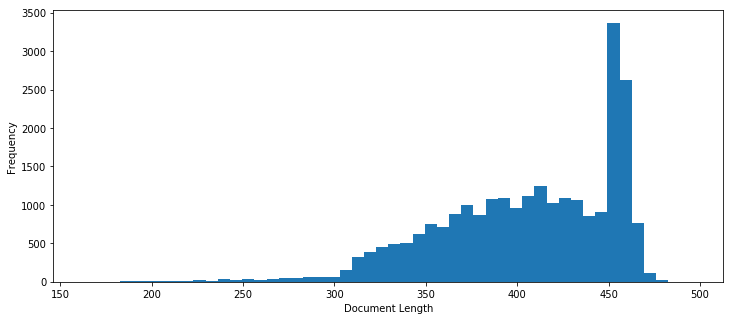

In [371]:
# histogram of document length 
doc_lenghts = data.full_text.str.split().apply(lambda x: len(x))
plt.figure(figsize=(12,5))
plt.hist(doc_lenghts, bins=50)
plt.xlabel('Document Length')
plt.ylabel('Frequency')
plt.show()

In [152]:
# examing the document length 
print("Average document length: {} words".format(round(np.mean(doc_lenghts))))
print("Median document length: {} words".format(round(np.median(doc_lenghts))))
print("Max document length: {} words".format(round(np.max(doc_lenghts))))
print("Min document length: {} words".format(round(np.min(doc_lenghts))))

Average document length: 406 words
Median document length: 413.0 words
Max document length: 496 words
Min document length: 163 words


In [275]:
# average number of labels per document 
print("Avg. number of labels in dataset: {}".format(data['labels'].apply(lambda x: len(x)).mean()))

Avg. number of labels in dataset: 1.90524


### Encoding Labels with MultiLabelBinarizer

In [337]:
data['labels'].head()

doc_num
00100004    [semiconductor devices; electric solid state d...
00100005    [image data processing or generation, in gener...
00100008    [wind motors, circuit arrangements or systems ...
00100009    [shaping or joining of plastics; shaping of su...
00100010    [apparatus or devices for manifolding, duplica...
Name: labels, dtype: object

In [333]:
# converting labels into a binarized matrix with the labels as columns 
# and each patent document represented in one row
mlb = preprocessing.MultiLabelBinarizer()
labels = mlb.fit_transform(data['labels'])

# checking that the conversion worked as desired by verifying the counts of labels for each document prior and post 
assert data['labels'].apply(lambda x: len(x)).values.sum() == np.array(pd.DataFrame(labels).apply(lambda x: x.sum(),axis=1)).sum()

In [464]:
labels_df.iloc[:,[538]].sum()   #470

transmission of digital information, e.g. telegraphic communication     1300
dtype: int64

In [339]:
labels_df = pd.DataFrame(labels, columns=mlb.classes_)  #.apply(lambda x: x.sum(),axis=1)
labels_df.head()

,abrasive or related blasting with particulate material,accessory machines or apparatus; tools,acyclic or carbocyclic compounds,"acyclic, carbocyclic, or heterocyclic compounds containing elements other than carbon, hydrogen, halogen, oxygen, nitrogen, sulfur, selenium, or tellurium","additional work, such as equipping roads or the construction of platforms, helicopter landing stages, signs, snow fences, or the like",adhesives; non-mechanical aspects of adhesive processes in general; adhesive processes not provided for elsewhere; use of materials as adhesives,aerials,aeroplanes; helicopters,aids for music,air supply; draught-inducing; supplying non-combustible liquid or gas,...,working of wood not provided for in subclasses ; b27b-b27l; manufacture of specific wooden articles,"working or processing of sheet metal or metal tubes, rods or profiles without essentially removing material; punching",working or processing of wire,working stone or stone-like materials,working veneer or plywood,"working-up tar, pitch, asphalt, bitumen; pyroligneous acid","working-up; general processes of compounding; after-treatment not covered by subclasses c08b, c08c, c08f, c08g; or c08h;","workshop equipment, e.g. for marking-out work; storage means for workshops",woven fabrics; methods of weaving; looms,x-ray technique
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [336]:
print("We have {} classes:".format(len(mlb.classes_)))
print("")
for i in mlb.classes_: 
    print(i)

We have 590 classes:

abrasive or related blasting with particulate material
accessory machines or apparatus; tools 
acyclic or carbocyclic compounds 
acyclic, carbocyclic, or heterocyclic compounds containing elements other than carbon, hydrogen, halogen, oxygen, nitrogen, sulfur, selenium, or tellurium 
additional work, such as equipping roads or the construction of platforms, helicopter landing stages, signs, snow fences, or the like
adhesives; non-mechanical aspects of adhesive processes in general; adhesive processes not provided for elsewhere; use of materials as adhesives 
aerials 
aeroplanes; helicopters 
aids for music 
air supply; draught-inducing; supplying non-combustible liquid or gas 
air-conditioning; air-humidification; ventilation; use of air currents for screening 
alloys 
ammonia; cyanogen; compounds thereof 
amplifiers 
analogue computers 
animal husbandry; care of birds, fishes, insects; fishing; rearing or breeding animals, not otherwise provided for; new breeds o

In [477]:
# checking how many times does each label (i.e. class) appear in the data 
# we observe that the classes are a little unbalanced 
pl = labels_df.apply(lambda x: x.sum(),axis=0).sort_values(ascending=False)  #.plot.bar()
pl

semiconductor devices; electric solid state devices not otherwise provided for ;                                                                                                                                                                                                                     1614
electric digital data processing                                                                                                                                                                                                                                                                     1503
pictorial communication, e.g. television                                                                                                                                                                                                                                                             1310
transmission of digital information, e.g. telegraphic communication                                       

In [ ]:
from bokeh.io import show, output_file
from bokeh.plotting import figure

output_file("bars.html")
p = figure(x_range=list(pl.index), plot_height=250, title="Label Counts",
           toolbar_location=None, tools="")
p.vbar(x=list(pl.index), top=pl.values, width=0.1)
p.xgrid.grid_line_color = None
p.y_range.start = 0
show(p)

### Train Test Split

In [395]:
# train test split 
# you can change to data['label1'] to include only the first label 
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(data['full_text'], labels, test_size=0.2)

print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(20000,)
(5000,)
(20000, 590)
(5000, 590)


In [479]:
X_train.head()

doc_num
00106535    ink jet recording head and method for manufact...
00400474    color-coded optical fiber ribbon and die for m...
00306105    metallo-organic polymers for gas separation an...
99810433    automatic analyzer system an automatic analyze...
99303965    a free machining steel bearing bismuth and sul...
Name: full_text, dtype: object

In [379]:
# print("Avg. number of labels in train set: {}".format(Y_train.apply(lambda x: len(x)).mean()))
# print("Avg. number of labels in test set: {}".format(Y_test.apply(lambda x: len(x)).mean()))

### Word Embeddings

**Load the pre-trained embeddings using this command:**

`nohup curl -O https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki-news-300d-1M.vec.zip > curl.nohup.out 2>&1 &`

Check loading progress with this: `cat curl.nohup.out`

Unzipping the file with python: 

In [68]:
current_dir

'/home/c.papadimitriou/W266-Final-Project'

In [70]:
zip_ref = zipfile.ZipFile('/home/c.papadimitriou/wiki-news-300d-1M.vec.zip', 'r')
zip_ref.extractall('/home/c.papadimitriou/')
zip_ref.close()

In [156]:
# sequence length is set to 480 based on the doc length histogram above 
sequence_length = 480
embedding_dim = 300

In [84]:
# word-embeddings: representing documents using a dense vector representation
# Word embeddings can be trained using the input corpus itself or 
# can be generated using pre-trained word embeddings such as Glove, FastText, and Word2Vec

# step 1. Loading the pretrained word embeddings
embeddings_index = {}
for i, line in enumerate(open('../wiki-news-300d-1M.vec')):
    values = line.split()
    embeddings_index[values[0]] = np.asarray(values[1:], dtype='float32')

In [157]:
# step 2. Creating a tokenizer object using Keras preprocessing object 
# the tokenizer has a default filter that removes all punctuation, plus tabs and line breaks, minus the ' character.
token = text.Tokenizer()
token.fit_on_texts(data['full_text'])
word_index = token.word_index

In [481]:
#word_index

In [159]:
print('Number of words in our vocabulary: {}'.format(len(word_index.keys())))

Number of words in our vocabulary: 72113


In [160]:
# step 3. Transforming text documents to sequence of tokens and padding them to ensure equal length vectors
# choosing the median document length as max length for padding 
X_train_seq = sequence.pad_sequences(token.texts_to_sequences(X_train), maxlen=sequence_length)
X_test_seq = sequence.pad_sequences(token.texts_to_sequences(X_test), maxlen=sequence_length)

In [170]:
print(X_train_seq.shape)
print(X_test_seq.shape)

(20000, 480)
(5000, 480)


In [171]:
# step 4. Creating a mapping of tokens and their respective embeddings
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [173]:
embedding_matrix.shape

(72114, 300)

### CNN model

In [433]:
# Define Parameters 
batch_size = 32
epochs = 5

vocabulary_size = len(word_index) + 1
sequence_length = sequence_length
embedding_dim = embedding_dim
num_filters = 100
filter_sizes = [3]
kernel_size = 3 # 3 by emb dim 
units = Y_train.shape[1]      # pd.Series(Y_train).value_counts().shape[0] # change this to the number of classes! 

In [493]:
# Input Layer
input_layer = Input(shape=(sequence_length,), dtype='int32')

# Word embedding Layer
embedding_layer = Embedding(input_dim=vocabulary_size, output_dim=embedding_dim, input_length=sequence_length, 
                            weights=[embedding_matrix], trainable=False)(input_layer)
embedding_layer = SpatialDropout1D(0.3)(embedding_layer)

# Convolutional Layer
conv_layer = Conv1D(num_filters, kernel_size=kernel_size, activation="relu")(embedding_layer)

# Pooling Layer
pooling_layer = GlobalMaxPool1D()(conv_layer)

# Output Layers
output_layer1 = Dense(50, activation="relu")(pooling_layer)
output_layer1 = Dropout(0.25)(output_layer1)
output_layer2 = Dense(units= units, activation="sigmoid")(output_layer1) # softmax  sigmoid

# Compile the model
# NOTE: we compile the model using binary cross entropy rather than categorical CE, since the goal 
# is to treat each output labels as an independent Bernoulli distribution 
model = models.Model(inputs=input_layer, outputs=output_layer2,)
model.compile(optimizer=optimizers.Adam(lr=1e-3), 
              loss='binary_crossentropy', #   binary_crossentropy  categorical_crossentropy
              metrics=['accuracy', keras_metrics.precision(),keras_metrics.recall()]) # 'f1score', 'precision', 'recall'

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        (None, 480)               0         
_________________________________________________________________
embedding_20 (Embedding)     (None, 480, 300)          21634200  
_________________________________________________________________
spatial_dropout1d_20 (Spatia (None, 480, 300)          0         
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 478, 100)          90100     
_________________________________________________________________
global_max_pooling1d_16 (Glo (None, 100)               0         
_________________________________________________________________
dense_31 (Dense)             (None, 50)                5050      
_________________________________________________________________
dropout_16 (Dropout)         (None, 50)                0         
__________

In [460]:
# Training 
history = model.fit(X_train_seq, Y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)


Train on 18000 samples, validate on 2000 samples
Epoch 1/5
18000/18000 [==============================] - 38s 2ms/step - loss: 0.0427 - acc: 0.9883 - precision: 0.0036 - recall: 0.0094 - val_loss: 0.0187 - val_acc: 0.9968 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/5
18000/18000 [==============================] - 37s 2ms/step - loss: 0.0197 - acc: 0.9968 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.0187 - val_acc: 0.9968 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/5
18000/18000 [==============================] - 37s 2ms/step - loss: 0.0194 - acc: 0.9968 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.0187 - val_acc: 0.9968 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/5
18000/18000 [==============================] - 37s 2ms/step - loss: 0.0192 - acc: 0.9968 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.0187 - val_acc: 0.9968 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/5
18000/18000 [

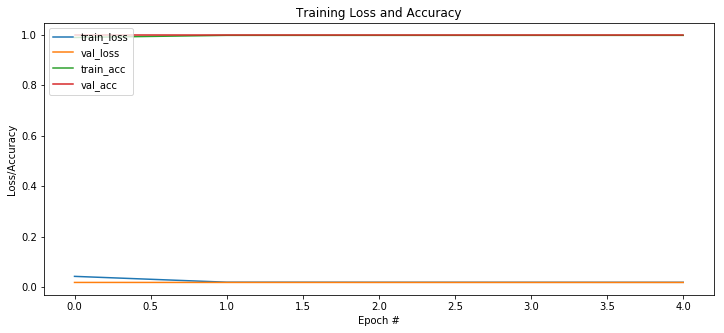

In [469]:
# Ploting the loss 
#history.history["loss"]

plt.figure(figsize=(12,5))
N = epochs
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left")

In [461]:
score = model.evaluate(X_test_seq, Y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Test score: 0.018736696964502336
Test accuracy: 0.9967837273597717


In [486]:
model.predict(X_test_seq)[0]

array([5.28774923e-04, 2.76723236e-04, 2.23309752e-02, 6.46771397e-03,
       8.92938406e-04, 7.80261820e-03, 7.27645634e-03, 5.84516441e-04,
       2.37129672e-04, 8.35821847e-04, 2.63374601e-03, 5.41065261e-03,
       3.14915873e-04, 2.10540369e-03, 1.38743519e-04, 6.10703649e-03,
       1.66371209e-03, 4.83762845e-03, 1.97236775e-03, 5.21960063e-03,
       2.33568484e-03, 7.30477332e-05, 5.62899467e-03, 1.87194243e-03,
       3.14834819e-04, 2.39105750e-04, 4.99256304e-04, 1.37607654e-04,
       1.50214462e-03, 9.27324314e-03, 4.27482603e-03, 9.56287701e-03,
       2.35944972e-04, 9.03637629e-05, 3.12255300e-03, 7.88775869e-05,
       2.82431225e-04, 5.79945736e-05, 3.69480404e-04, 2.16679485e-03,
       6.68898647e-05, 7.38007657e-05, 2.72392121e-04, 7.11003260e-04,
       7.62882584e-04, 1.11068613e-04, 5.95993886e-04, 1.52212320e-04,
       1.91117357e-03, 1.25133782e-04, 8.79723593e-05, 5.66465060e-05,
       3.11270676e-04, 6.26552064e-05, 2.16674569e-04, 4.63639200e-03,
      

In [474]:
proba = model.predict(X_test_seq)[1]
idxs = np.argsort(proba)[::-1][:2]
print(idxs)
print(np.sort(proba)[::-1][:2])

[538 164]
[0.07737717 0.07004652]


In [491]:
Y_test[1]
#np.argsort(Y_test[1])[::-1][:2]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

### Evaluation Metrics

**True Positives (TP)**: the number of labels predicted by our approach (prediction labels) that
matched the IPC labels (true labels), without taking the exact order into account.

**False Positives (FP)**: the labels predicted by our approach (prediction labels) that do not match the true IPC labels. 

**False Negatives (FN)**: the labels that should have been predicted by our approach, but were not.

**True Negatives (TN)**: the labels that, correctly, were not predicted by our approach. 


$$ Precision = \frac{TP}{TP + FP} = \frac{trueLabels \cap predictionLabels}{predictionLabels} $$

$$ Recall = \frac{TP}{TP + FN} = \frac{trueLabels \cap predictionLabels}{trueLabels} $$

**Precision** shows the ratio of the predicted labels that are true labels.

**Recall** shows the ratio of the true labels that were predicted correctly. 

After calculating the above metrics for each patent document, we calculate the final Precision, Recall and F1-score across all documents as follows: 

$$Precision_{total} = \frac{1}{TotalSamples} \sum_{n=i}^{TotalSamples} Precision_i$$

$$Recall_{total} = \frac{1}{TotalSamples} \sum_{n=i}^{TotalSamples} Recall_i$$

$$F1_{total} = 2* \frac{Precision_{total}*Recall_{total}}{Precision_{total}+Recall_{total}}  $$

### Error Analysis

In [466]:
model.predict(X_test_seq)[100]


array([5.92865341e-04, 3.01415334e-04, 2.36083064e-02, 6.84909802e-03,
       9.69777757e-04, 8.47762823e-03, 7.70767638e-03, 6.92555564e-04,
       2.57148349e-04, 9.47743189e-04, 2.81866686e-03, 5.77301905e-03,
       3.49867769e-04, 2.39308528e-03, 1.62545344e-04, 6.92318659e-03,
       1.71949179e-03, 5.31390356e-03, 2.17994233e-03, 5.59421256e-03,
       2.58543016e-03, 8.55640756e-05, 6.04117662e-03, 2.04578438e-03,
       3.60888866e-04, 2.58674641e-04, 5.48834563e-04, 1.56376103e-04,
       1.56002294e-03, 9.74122714e-03, 4.52442886e-03, 1.04114627e-02,
       2.77904794e-04, 9.63926213e-05, 3.41320527e-03, 9.22729159e-05,
       3.09929572e-04, 6.09268136e-05, 3.77434219e-04, 2.31152866e-03,
       7.49768806e-05, 8.60306682e-05, 3.09764146e-04, 8.04160663e-04,
       8.35152750e-04, 1.29920649e-04, 6.88550994e-04, 1.70716114e-04,
       2.07651546e-03, 1.42738718e-04, 9.65562795e-05, 7.05370185e-05,
       3.47676600e-04, 6.63173487e-05, 2.58693646e-04, 5.16995694e-03,
      

In [494]:
for i in range(5):
    print(model.predict(X_test_seq)[i].argmax())
#model.predict(X_test_seq)[4].argmax()

373
117
117
373
373


In [468]:
model.predict(X_test_seq)[0].max()

0.07178062

In [447]:
Y_test[2].argmax()

552

## Model 

In [ ]:
# define parameters
batch_size = 32
epochs = 2

In [ ]:
# simple fully connected layer NN

model = Sequential()
model.add(Dense(512, input_shape=(max_words,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)

score = model.evaluate(x_test, y_test,
                       batch_size=batch_size, verbose=1)
print('Test score:', score[0])
print('Test accuracy:', score[1])


In [ ]:
# fit